In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set()
pd.set_option('max_columns', 400)

In [2]:
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
from sklearn.utils.testing import ignore_warnings

## Загрузка и подготовка первичных данных

### Задача: 
по имеющимся данным построить модель, которая может предсказать увольнение МП на горизонте 3 мес.
Задача бинарной классификации. 

Для определения качества будем использовать `accuracy`, `f1-score`, а также `roc-auc` для интереса (т.к. `roc-auc` применялся в оригинальном соревновании откуда я взял датасет).\
Имеется DF с шейпом (>440000,397).\
Начнем работу с выборками train&test по 10 тыс строчек, при возможности расширим до 100 тыс.
Тестирование проведем на новых данных test.
По части столбцов есть пояснения о их значении (у меня в виде отдельного xlsx).
По некоторым столбцам без расшифровок можно догадаться о их значении.

In [6]:
# import pandas as pd
# target_lag = pd.read_csv("../input/prediction-of-dismissal/target_lag.csv")
# train_data = pd.read_csv("../input/prediction-of-dismissal/train_data.csv")

In [7]:
data = pd.read_csv("train_data.csv", sep=',', low_memory=False, nrows=10000)

In [8]:
df_train = data

In [9]:
data.shape

(10000, 397)

In [10]:
data.head()

C_Year  EtalonPosName R_Year  age_qty  boss_pos_name  \
0    NaN            0.0    NaN     27.0            0.0   
1      C            0.0      C     24.0            0.0   
2      D            0.0      C     52.0            0.0   
3    NaN            0.0    NaN     28.0            0.0   
4    NaN            0.0    NaN     25.0            0.0   

   boss_subord_1y_max_qty  boss_subord_1y_min_qty  boss_subord_in_1m_qty  \
0                    28.0                     0.0                    1.0   
1                    31.0                    26.0                    2.0   
2                    31.0                    26.0                    1.0   
3                    15.0                    14.0                    2.0   
4                    13.0                    12.0                    0.0   

   boss_subord_in_1y_qty  boss_subord_out_1m_qty  boss_subord_out_1y_qty  \
0                   29.0                     1.0                    29.0   
1                   23.0                     2.0                    20.0   
2                   19.0                     2.0                    15.0   
3                    3.0                     2.0                     2.0   
4                    5.0                     1.0                     6.0   

   boss_subord_qty  boss_tabnum  crd_cc_act_qty  crd_cc_act_spend_qty  \
0             28.0            0             0.0                   0.0   
1             30.0            1             1.0                   1.0   
2             30.0            2             1.0                   1.0   
3             15.0            3             0.0                   0.0   
4             12.0            4             1.0                   1.0   

   crd_cc_ever_nflag  crd_cc_mnth_snc_issue_frac  crd_cc_mnth_snc_issue_qty  \
0                1.0                        69.9                      70.00   
1                1.0                         3.1                       3.13   
2                1.0                        57.4                      57.58   
3                1.0                         NaN                        NaN   
4                1.0                        45.6                      45.74   

   crd_cc_overdue_nflag  crd_cc_own_bal_rub_amt  crd_cc_pos_auto_qty  \
0                   0.0                0.005303                  NaN   
1                   0.0                0.000000                  NaN   
2                   0.0                0.000019                  NaN   
3                   0.0                0.000000                  NaN   
4                   0.0                0.000000                  NaN   

   crd_cc_pos_auto_rub_amt  crd_cc_pos_beuaty_qty  crd_cc_pos_beuaty_rub_amt  \
0                      NaN                    NaN                        NaN   
1                      NaN                    NaN                        NaN   
2                      NaN                    NaN                        NaN   
3                      NaN                    NaN                        NaN   
4                      NaN                    NaN                        NaN   

   crd_cc_pos_clothes_qty  crd_cc_pos_clothes_rub_amt  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     NaN                         NaN   

   crd_cc_pos_dept_stores_qty  crd_cc_pos_dept_stores_rub_amt  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   crd_cc_pos_eat_out_qty  crd_cc_pos_eat_out_rub_amt  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2     

Проверяем значения таргета, создадим дата фрейм `target_pd` формата пандас

In [12]:
target = df_train[['target_churn_lag1m']]
target_pd = pd.DataFrame(target)
print(pd.unique(data[['target_churn_lag1m']].values.ravel('K')))

# узнаем индекс таргета
data.columns.get_loc('target_churn_lag1m')

[0. 1.]


339

Проверим распределение целевого признака - распределение неравномерное, очень мало данных по уволившимся.
Для адекватного обучения придется выбирать отдельные строки по уволившимся из основного файла данных.
Также снизим кол-во строчек по не уволенным сотрудникам.

Text(0.5, 1.0, 'target')

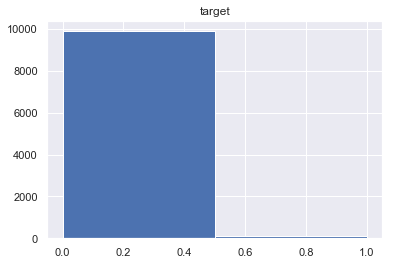

In [13]:
fig, axs = plt.subplots()
axs.hist(target_pd['target_churn_lag1m'], bins=2)
axs.set_title('target')

Всего 106 строчек по уволенным, этого очень мало для нормального обучения

In [14]:
target_pd.target_churn_lag1m.value_counts()

0.0    9894
1.0     106
Name: target_churn_lag1m, dtype: int64

Для улучшения распределения целевого признака считаем все строки из файла со значением таргета == 1.0.
В дальнейшем будем создавать трейн и тест с ипользованием данного DF.
Прочитаем файл и сохраним таблицу в новый DF, отбросим строчки с таргет == 0.0.

In [15]:
# f = pd.read_csv('C:\\Users\\XXX\\Downloads\\train (1)\\train.csv', sep=',', low_memory=False) читаем исходник
# data_t =  pd.DataFrame(f.drop(f[f.target_churn_lag1m == 0.0].index)) выкидываем строчки с таргетом == 0.0
data_t = pd.read_csv('target_lag.csv', sep=',', index_col = 0)

type(data_t)

pandas.core.frame.DataFrame

Проверим данные, в столбце target_churn_lag1m все ок

In [16]:
data_t.head()

C_Year  EtalonPosName R_Year  age_qty  boss_pos_name  \
0    NaN            0.0    NaN     28.0            0.0   
1    NaN            0.0    NaN     29.0            0.0   
2    NaN            0.0    NaN     29.0            0.0   
3      C            0.0      C     26.0            0.0   
4      C            0.0      C     24.0            0.0   

   boss_subord_1y_max_qty  boss_subord_1y_min_qty  boss_subord_in_1m_qty  \
0                    15.0                    14.0                    2.0   
1                    13.0                    11.0                    0.0   
2                    12.0                    10.0                    0.0   
3                    18.0                    14.0                    1.0   
4                    34.0                    34.0                    0.0   

   boss_subord_in_1y_qty  boss_subord_out_1m_qty  boss_subord_out_1y_qty  \
0                    3.0                     2.0                     2.0   
1                    5.0                     0.0                     4.0   
2                    5.0                     0.0                     2.0   
3                   31.0                     1.0                    31.0   
4                    0.0                     0.0                     0.0   

   boss_subord_qty  boss_tabnum  crd_cc_act_qty  crd_cc_act_spend_qty  \
0             15.0            3             0.0                   0.0   
1             13.0           10             0.0                   0.0   
2             12.0           66             1.0                   1.0   
3             15.0          167             0.0                   0.0   
4             34.0           90             1.0                   1.0   

   crd_cc_ever_nflag  crd_cc_mnth_snc_issue_frac  crd_cc_mnth_snc_issue_qty  \
0                1.0                         NaN                        NaN   
1                0.0                         NaN                        NaN   
2                1.0                        25.8                      25.81   
3                0.0                         NaN                        NaN   
4                1.0                         7.1                       7.10   

   crd_cc_overdue_nflag  crd_cc_own_bal_rub_amt  crd_cc_pos_auto_qty  \
0                   0.0                     0.0                  NaN   
1                   0.0                     NaN                  NaN   
2                   0.0                     0.0                  NaN   
3                   0.0                     NaN                  NaN   
4                   0.0                     0.0                 28.0   

   crd_cc_pos_auto_rub_amt  crd_cc_pos_beuaty_qty  crd_cc_pos_beuaty_rub_amt  \
0                      NaN                    NaN                        NaN   
1                      NaN                    NaN                        NaN   
2                      NaN                    NaN                        NaN   
3                      NaN                    NaN                        NaN   
4                 0.681909                    1.0                   0.018745   

   crd_cc_pos_clothes_qty  crd_cc_pos_clothes_rub_amt  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     2.0                    0.213197   

   crd_cc_pos_dept_stores_qty  crd_cc_pos_dept_stores_rub_amt  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   crd_cc_pos_eat_out_qty  crd_cc_pos_eat_out_rub_amt  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2     

Проверим количество строк.
Итого на >440000 строк всего 3598 с данными по уволившимся МП.

In [17]:
print(data_t.shape)

(3598, 397)


Сохраним данные в отдельный файл, чтобы в дальнейшем не нужно было использовать тяжелый исходник.

In [18]:
# data_t.to_csv('target_lag.csv')

In [19]:
data_target_train = pd.read_csv('target_lag.csv', 
                                sep=',', nrows=2500, index_col = 0)
# data_target_train = data_target_train.drop(data_target_train.columns[[0]], axis='columns')

Начнем готовить трейн.

In [20]:
df_short = data.drop(data[data.target_churn_lag1m == 1.0].index)
df_short.index = pd.RangeIndex(len(df_short.index))
print(df_short.shape)
df_train = df_short[:3500]
print(df_train.shape)

(9894, 397)
(3500, 397)


Присоедим строчки с таргетом к трейн.

In [21]:
df_train = pd.concat([df_train,data_target_train],axis=0)
df_train.index = pd.RangeIndex(len(df_train.index))
df_train.shape

(6000, 397)

Теперь расределение гораздо лучше.

Text(0.5, 1.0, 'target')

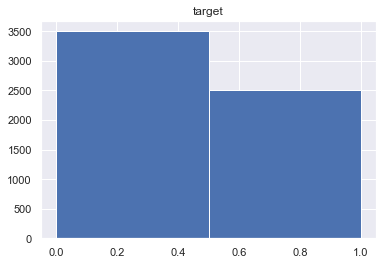

In [22]:
fig, axs = plt.subplots()
axs.hist(df_train['target_churn_lag1m'], bins=2, range=(0, 1))
axs.set_title('target')

Проведем аналогичные манипуляции для тестовой выборки.

In [23]:
df_test = df_short[3500:5402]
df_test.shape

(1902, 397)

In [24]:
data_target_test = pd.read_csv('target_lag.csv', 
                               sep=',', index_col = 0)
data_target_test = data_target_test.drop(data_target_test[:2500].index)
print(data_target_test.shape)
df_test = pd.concat([df_test,data_target_test],axis=0)
df_test.index = pd.RangeIndex(len(df_test.index))
df_test.shape

(1098, 397)


(3000, 397)

## Подготовка данных

### Аналитика

Посмотрим на данные.

In [25]:
df_train.iloc[:, :100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
C_Year                            3916 non-null object
EtalonPosName                     5919 non-null float64
R_Year                            3917 non-null object
age_qty                           5996 non-null float64
boss_pos_name                     5977 non-null float64
boss_subord_1y_max_qty            5968 non-null float64
boss_subord_1y_min_qty            5968 non-null float64
boss_subord_in_1m_qty             5968 non-null float64
boss_subord_in_1y_qty             5968 non-null float64
boss_subord_out_1m_qty            5968 non-null float64
boss_subord_out_1y_qty            5968 non-null float64
boss_subord_qty                   5968 non-null float64
boss_tabnum                       6000 non-null int64
crd_cc_act_qty                    5980 non-null float64
crd_cc_act_spend_qty              5980 non-null float64
crd_cc_ever_nflag                 5997 non-null float64


In [26]:
df_train.iloc[:, 100:200].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
crd_inf_cc_total_qty                 3057 non-null float64
crd_inf_cc_total_rub_amt             3057 non-null float64
crd_inf_dc_total_qty                 5963 non-null float64
crd_inf_dc_total_rub_amt             5963 non-null float64
crd_inf_ext_transf_qty               5743 non-null float64
crd_inf_ext_transf_rb_am_a_3m        5788 non-null float64
crd_inf_ext_transf_rb_am_a_6m        5819 non-null float64
crd_inf_ext_transf_rub_amt           5743 non-null float64
crd_inf_ext_transf_rub_amt_sum_3m    5985 non-null float64
crd_inf_ext_transf_rub_amt_sum_6m    5819 non-null float64
crd_inf_othr_qty                     5964 non-null float64
crd_inf_othr_rub_amt                 5964 non-null float64
crd_inf_pos_ret_qty                  767 non-null float64
crd_inf_pos_ret_rub_amt              767 non-null float64
crd_inf_total_qty                    5964 non-null float64
crd_inf_t

In [32]:
df_train.iloc[:, 200:300].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
lbt_otf_total_rub_amt            5959 non-null float64
lbt_payroll_client_nflag         5997 non-null float64
lbt_payroll_l3m_tot_rub_amt      5902 non-null float64
lbt_payroll_l6m_avg_r_am_a_3m    5921 non-null float64
lbt_payroll_l6m_avg_r_am_a_6m    5930 non-null float64
lbt_payroll_l6m_avg_r_am_s_3m    5986 non-null float64
lbt_payroll_l6m_avg_r_am_s_6m    5930 non-null float64
lbt_payroll_l6m_tot_rub_amt      5915 non-null float64
lbt_payroll_min_dt               5953 non-null object
lbt_payroll_tax_payer_cd         5859 non-null float64
lbt_social_client_nflag          5997 non-null float64
lne_mg_agr_clsd_00_ever_qty      4574 non-null float64
lne_mg_agr_open_ever_qty         4574 non-null float64
lne_mg_agr_open_qty              4574 non-null float64
lne_mg_debt_os_rub_amt           4574 non-null float64
lne_mg_dq_entr_ever_qty          4574 non-null float64
lne_mg_max_ov

In [33]:
df_train.iloc[:, 300:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 97 columns):
prd_pl_active_qty                 5997 non-null float64
prd_pl_activity_ind               5997 non-null float64
prd_sc_active_nflag               5997 non-null float64
prd_sc_active_qty                 5997 non-null float64
prd_sc_activity_ind               5997 non-null float64
prd_yrs_lst_open_qty              5982 non-null float64
report_dt                         6000 non-null object
report_quarter_qty                6000 non-null int64
schedule_name                     5990 non-null float64
sd_client_valid_nflag             5997 non-null float64
sd_name_age_segment_cd            5997 non-null float64
sd_resident_nflag                 5997 non-null float64
sd_russian_citizen_nflag          5997 non-null float64
sd_stlmnt_type_cd                 5392 non-null float64
seg_client_segment_cd             5997 non-null float64
seg_crd_txn_mcc_cluster_id        5997 non-null float64


In [34]:
df_test.iloc[:, :100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 100 columns):
C_Year                            2414 non-null object
EtalonPosName                     2993 non-null float64
R_Year                            2414 non-null object
age_qty                           2997 non-null float64
boss_pos_name                     2989 non-null float64
boss_subord_1y_max_qty            2988 non-null float64
boss_subord_1y_min_qty            2988 non-null float64
boss_subord_in_1m_qty             2988 non-null float64
boss_subord_in_1y_qty             2988 non-null float64
boss_subord_out_1m_qty            2988 non-null float64
boss_subord_out_1y_qty            2988 non-null float64
boss_subord_qty                   2988 non-null float64
boss_tabnum                       3000 non-null int64
crd_cc_act_qty                    2998 non-null float64
crd_cc_act_spend_qty              2998 non-null float64
crd_cc_ever_nflag                 2999 non-null float64


In [35]:
df_test.iloc[:, 100:200].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 100 columns):
crd_inf_cc_total_qty                 1591 non-null float64
crd_inf_cc_total_rub_amt             1591 non-null float64
crd_inf_dc_total_qty                 2993 non-null float64
crd_inf_dc_total_rub_amt             2993 non-null float64
crd_inf_ext_transf_qty               2908 non-null float64
crd_inf_ext_transf_rb_am_a_3m        2919 non-null float64
crd_inf_ext_transf_rb_am_a_6m        2936 non-null float64
crd_inf_ext_transf_rub_amt           2908 non-null float64
crd_inf_ext_transf_rub_amt_sum_3m    2999 non-null float64
crd_inf_ext_transf_rub_amt_sum_6m    2936 non-null float64
crd_inf_othr_qty                     2994 non-null float64
crd_inf_othr_rub_amt                 2994 non-null float64
crd_inf_pos_ret_qty                  338 non-null float64
crd_inf_pos_ret_rub_amt              338 non-null float64
crd_inf_total_qty                    2994 non-null float64
crd_inf_t

In [36]:
df_test.iloc[:, 200:300].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 100 columns):
lbt_otf_total_rub_amt            2986 non-null float64
lbt_payroll_client_nflag         2999 non-null float64
lbt_payroll_l3m_tot_rub_amt      2977 non-null float64
lbt_payroll_l6m_avg_r_am_a_3m    2986 non-null float64
lbt_payroll_l6m_avg_r_am_a_6m    2988 non-null float64
lbt_payroll_l6m_avg_r_am_s_3m    2999 non-null float64
lbt_payroll_l6m_avg_r_am_s_6m    2988 non-null float64
lbt_payroll_l6m_tot_rub_amt      2981 non-null float64
lbt_payroll_min_dt               2987 non-null object
lbt_payroll_tax_payer_cd         2959 non-null float64
lbt_social_client_nflag          2999 non-null float64
lne_mg_agr_clsd_00_ever_qty      2351 non-null float64
lne_mg_agr_open_ever_qty         2351 non-null float64
lne_mg_agr_open_qty              2351 non-null float64
lne_mg_debt_os_rub_amt           2351 non-null float64
lne_mg_dq_entr_ever_qty          2351 non-null float64
lne_mg_max_ov

In [37]:
df_test.iloc[:, 300:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 97 columns):
prd_pl_active_qty                 2999 non-null float64
prd_pl_activity_ind               2999 non-null float64
prd_sc_active_nflag               2999 non-null float64
prd_sc_active_qty                 2999 non-null float64
prd_sc_activity_ind               2999 non-null float64
prd_yrs_lst_open_qty              2998 non-null float64
report_dt                         3000 non-null object
report_quarter_qty                3000 non-null int64
schedule_name                     2998 non-null float64
sd_client_valid_nflag             2999 non-null float64
sd_name_age_segment_cd            2999 non-null float64
sd_resident_nflag                 2999 non-null float64
sd_russian_citizen_nflag          2999 non-null float64
sd_stlmnt_type_cd                 2699 non-null float64
seg_client_segment_cd             2999 non-null float64
seg_crd_txn_mcc_cluster_id        2999 non-null float64


Посмотрим на пропуски.

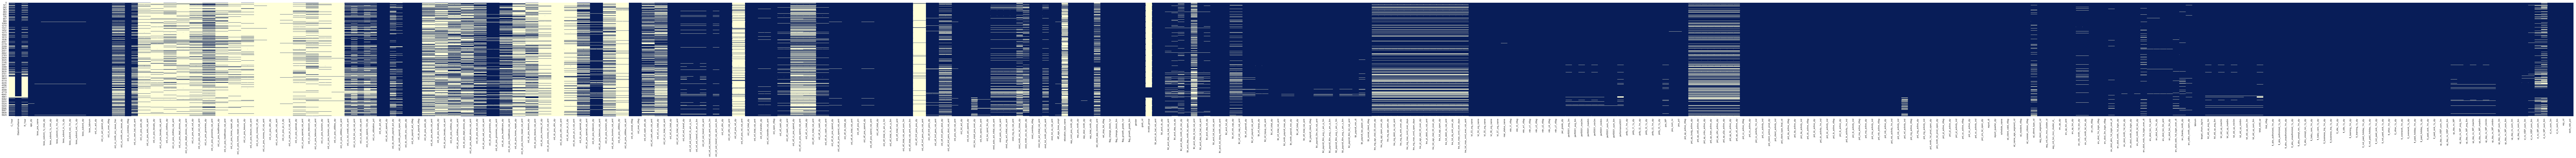

In [38]:
fig, ax = plt.subplots(figsize=(220,10))
sns.heatmap(df_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

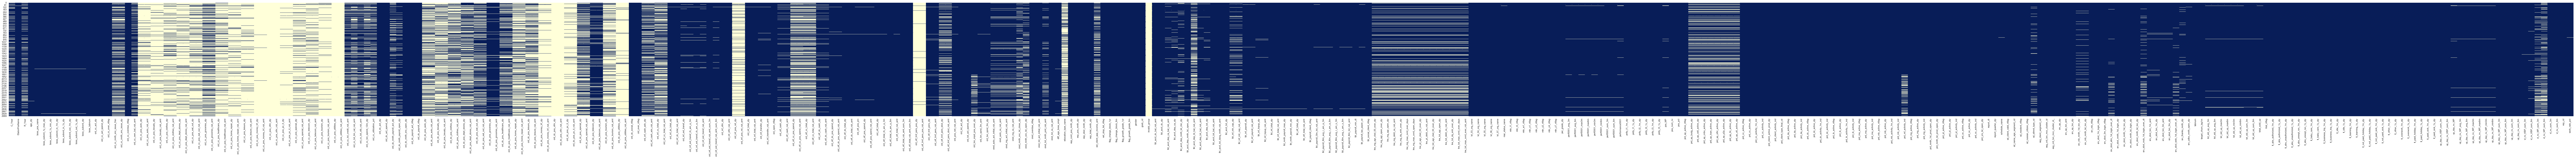

In [39]:
fig, ax = plt.subplots(figsize=(220,10))
sns.heatmap(df_test.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

Посмотрим на тепловую карту матрицы корреляций.
Видим, что часть данных коррелируют - операции по КК, операции по дебетовкам, общие суммы трат за 3 и 6 мес.

In [40]:
plt.subplots(figsize=(150,150))
sns.heatmap(df_train.corr(), square=True)
plt.show()

Посмотрим на зависимость целевого признака от оценок 5+ за результат и по компетенциям.
Видим большой разброс по оценкам Е и А, но они самые редкие
По основной массе оценок С, В и D пересечение только в оценке компетенций между В и D

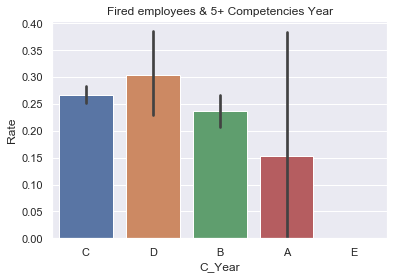

In [41]:
sns.barplot(x='C_Year', y='target_churn_lag1m', data=df_train)
plt.ylabel("Rate")
plt.title("Fired employees & 5+ Competencies Year")
plt.show()

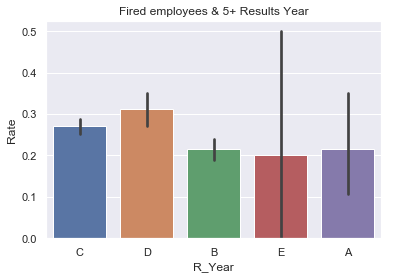

In [42]:
sns.barplot(x='R_Year', y='target_churn_lag1m', data=df_train)
plt.ylabel("Rate")
plt.title("Fired employees & 5+ Results Year")
plt.show()

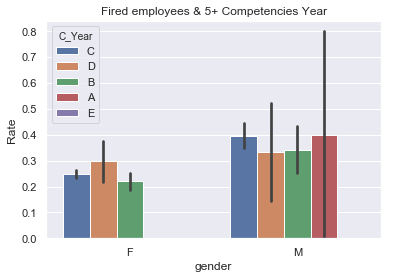

In [43]:
sns.barplot(x='gender', y='target_churn_lag1m', hue='C_Year', data=df_train)
plt.ylabel("Rate")
plt.title("Fired employees & 5+ Competencies Year")
plt.show()

Те же данные, но оценка результата.

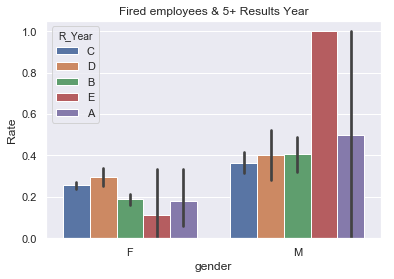

In [44]:
sns.barplot(x='gender', y='target_churn_lag1m', hue='R_Year', data=df_train)
plt.ylabel("Rate")
plt.title("Fired employees & 5+ Results Year")
plt.show()

Видим отсутствие очевидных зависимостей уволнения от оценок 5+ за год по компетенциям, кроме оценки В (хорошая оценка) - с такой оценкой увольнялись меньше.
С максимальной оценкой А всего 13 человек и их не видно на графике.

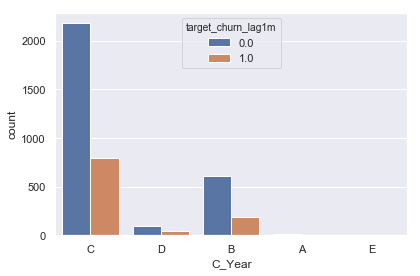

In [45]:
sns.countplot(df_train['C_Year'], hue=df_train['target_churn_lag1m'])
axs.set_title('C_Year', fontsize=14, fontweight='bold')
plt.tight_layout()

Аналогичные данные, но оценка по результату.

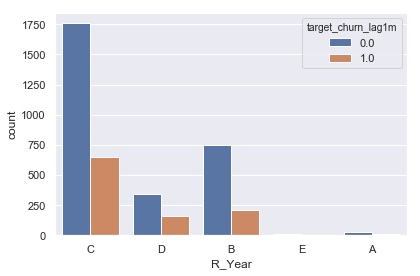

In [46]:
sns.countplot(df_train['R_Year'], hue=df_train['target_churn_lag1m'])
axs.set_title('R_Year', fontsize=14, fontweight='bold')
plt.tight_layout()

Следующий момент, который хочется проверить - увольнения с действующими ипотеками.
Количество ипотек от 0 до 5.

In [47]:
df_train.lne_mg_agr_open_qty.value_counts()

0.0    3515
1.0    1015
2.0      37
4.0       3
3.0       3
5.0       1
Name: lne_mg_agr_open_qty, dtype: int64

Наличие ипотеки ожидаемо снизило количество уволенных по сравнению с МП без ипотеки.

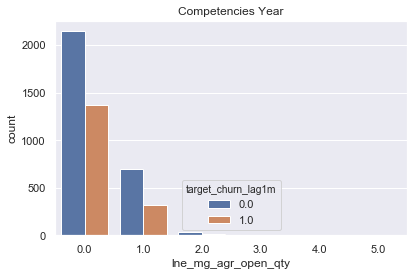

In [48]:
sns.countplot(df_train['lne_mg_agr_open_qty'], hue=df_train['target_churn_lag1m'])
axs.set_title('lne_mg_agr_open_qty', fontsize=14, fontweight='bold')
plt.tight_layout()

Также интересно проверить отчетный квартал - по идее в 4м квартале должны увольняться меньше из-за годового бонуса

4    4169
1     729
3     578
2     524
Name: report_quarter_qty, dtype: int64

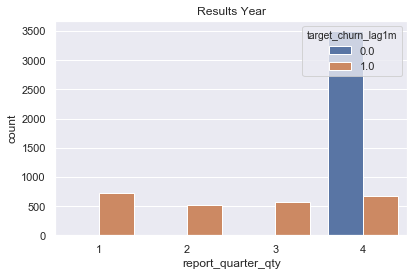

In [49]:
sns.countplot(df_train['report_quarter_qty'], hue=df_train['target_churn_lag1m'])
axs.set_title('report_quarter_qty', fontsize=14, fontweight='bold')
plt.title("Results Year")
plt.tight_layout()

df_train.report_quarter_qty.value_counts()

Видим, что данные в csv были отранжированы по датам и когда мы взяли 3500 первых строк исходника, то все они оказались из 4 квартала.
По правильному надо перепаковать данные, но т.к. время ограничено мы просто удалим данный столбец, чтобы он не влиял на модель.
Также можно сделать вывод, что на протяжении квартала количество уволенных примерно одинаково и гипотеза о более низком уровне увольнений в 4 квартале не верна.

Здесь смотрим распределение по возрасту, полу и семейному положению.
К сожалению, расшифровок статусов семейного положения нет.
Видим, что в среднем мужчины увольняются чаще девушек (уволенных больше, чем работающих).

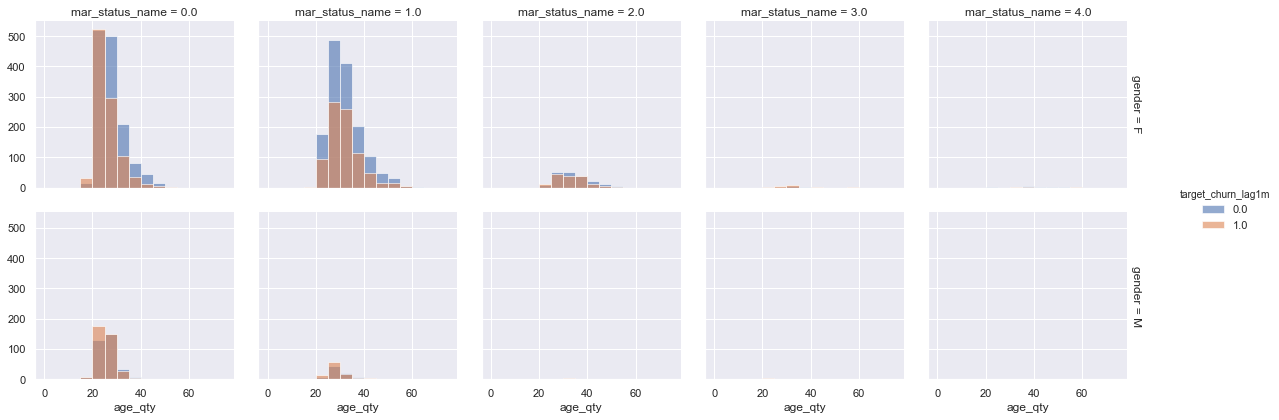

In [50]:
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(df_train, row='gender', col='mar_status_name', 
                  hue='target_churn_lag1m', margin_titles=True, 
                  size=3, aspect=1.1)
g.map(sns.distplot, 'age_qty', kde=False, bins=bins, hist_kws=dict(alpha=0.6))
g.add_legend()  
plt.show()  

Можем отметить, что с возрастом увольнений у женщин меньше (старше 40 лет).
А у мужчин меньше увольнений при возрасте около 35 лет.

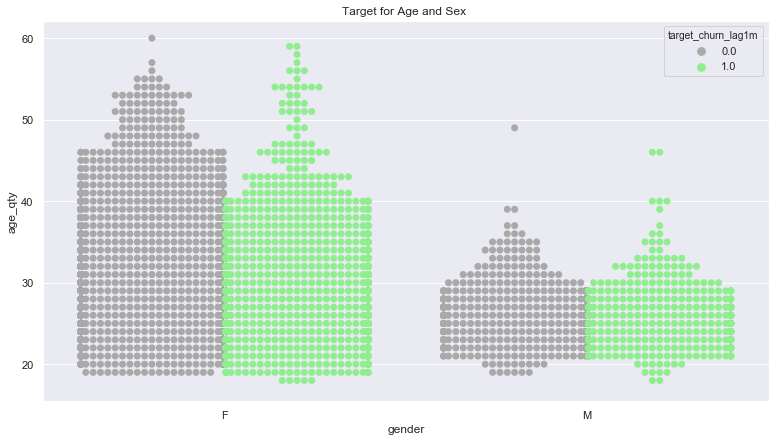

In [51]:
cm_surv = ["darkgrey" , "lightgreen"]
fig, ax = plt.subplots(figsize=(13,7))
sns.swarmplot(x='gender', y='age_qty', hue='target_churn_lag1m', split=True, 
              data=df_train, palette=cm_surv, size=7, ax=ax)
plt.title('Target for Age and Sex ')
plt.show()

Посмотрим на диаграмму рассеяния для пары признаков совокупная задолженность по кредитам и возраст
Линейной зависимости нет

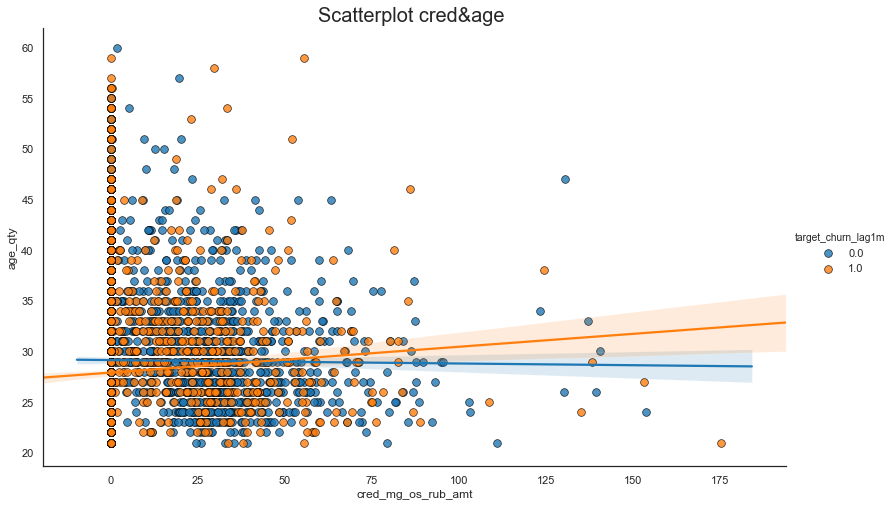

In [52]:
col1 = 'cred_mg_os_rub_amt'  #Совокупная задолженность кредитам 
col2 = 'age_qty'             #Флаг наличия просроченной задолженности по кредиту 
t = 'target_churn_lag1m'
# df_train['cred_mg_os_rub_amt'] = df_train['cred_mg_os_rub_amt'].fillna(0.0, axis=0)
# df_train['cred_overdue_nflag'] = df_train['cred_overdue_nflag'].fillna(0.0, axis=0)


sns.set_style("white")
gridobj = sns.lmplot(x=col1, y=col2, 
                     hue=t, data=df_train, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

plt.title("Scatterplot cred&age ", fontsize=20)
plt.show()

Диаграмма стажа и оплачиваемого отпуска
Линейной зависимости нет

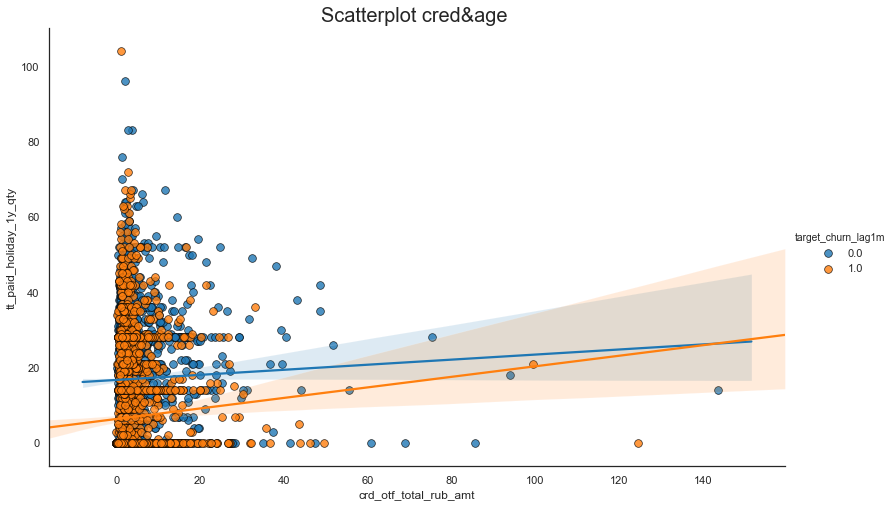

In [53]:
col1 = 'crd_otf_total_rub_amt'    #кол-во месяцев общего стажа
col2 = 'tt_paid_holiday_1y_qty'   #кол-во дней отпуска
t = 'target_churn_lag1m'

sns.set_style("white")
gridobj = sns.lmplot(x=col1, y=col2, 
                     hue=t, data=df_train, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

plt.title("Scatterplot cred&age ", fontsize=20)
plt.show()

### Обработка данных

Выделим числовые и категориальные признаки.\
Первые 2 столбца - оценка 5+ за год, их оставим, т.к.они могут повлиять на целевую переменную \
Третий - пол (Последнее значение пола в витрине-источнике для табельного номера)\
lbt_payroll_min_dt - Минимальная дата получения зарплатных начислений (накопительным итогом)\
report_dt - Отчетная дата (конец месяца). Теоретически может повлиять из-за премий\
Gо оставшимся трем данных о значении нет, видимо они связаны то ли с датой первого получения логина сбол, то ли с датой первого захода в интернет-банк, сбол и АТМ

In [27]:
categorical_columns = [c for c in df_train.columns if df_train[c].dtype.name == 'object']
numerical_columns   = [c for c in df_train.columns if df_train[c].dtype.name != 'object']
print(categorical_columns)
# print(numerical_columns)

['C_Year', 'R_Year', 'gender', 'lbt_payroll_min_dt', 'report_dt', 'srv_sbol_atm_1st_login_ever_dt', 'srv_sbol_mob_1st_login_ever_dt', 'srv_sbol_web_1st_login_ever_dt']


Посмотрим общую информацию по категориальным признакам.\
В данной работе я не буду использовать временные данные и удалю столбцы с датами

In [28]:
df_train[categorical_columns].describe()

C_Year R_Year gender lbt_payroll_min_dt   report_dt  \
count    3916   3917   6000               5953        6000   
unique      5      5      2               1053          34   
top         C      C      F         05.07.2012  30.11.2017   
freq     2973   2409   5111                578        3711   

       srv_sbol_atm_1st_login_ever_dt srv_sbol_mob_1st_login_ever_dt  \
count                            5814                           5516   
unique                            924                           1010   
top                        15.01.2015                     01.01.2015   
freq                               43                            426   

       srv_sbol_web_1st_login_ever_dt  
count                            5810  
unique                            804  
top                        01.01.2015  
freq                              218

Cтолбцы с 5+ заполним средним значением "C" и удалим столбцы с датами, а также 4 столбца без значений: \
'crd_cc_pos_othr_qty', 'crd_cc_pos_othr_rub_amt' и 'crd_dc_pos_othr_qty', 'crd_dc_pos_othr_rub_amt'\
и столбец с цифрой отчетного квартала 'report_quarter_qty'

In [29]:
for df in [df_train, df_test]:
    df['C_Year'] = df['C_Year'].fillna('C')
    df['R_Year'] = df['R_Year'].fillna('C')

df_train = df_train.drop(['crd_cc_pos_othr_qty', 'crd_cc_pos_othr_rub_amt', 'lbt_payroll_min_dt', 'report_dt', 
                                  'srv_sbol_atm_1st_login_ever_dt', 'srv_sbol_mob_1st_login_ever_dt', 
                                  'srv_sbol_web_1st_login_ever_dt', 'crd_dc_pos_othr_qty', 
                          'crd_dc_pos_othr_rub_amt', 'report_quarter_qty'], axis=1)
df_test = df_test.drop(['crd_cc_pos_othr_qty', 'crd_cc_pos_othr_rub_amt', 'lbt_payroll_min_dt', 'report_dt', 
                                  'srv_sbol_atm_1st_login_ever_dt', 'srv_sbol_mob_1st_login_ever_dt', 
                                  'srv_sbol_web_1st_login_ever_dt', 'crd_dc_pos_othr_qty', 
                        'crd_dc_pos_othr_rub_amt', 'report_quarter_qty'],axis=1)

In [30]:
# столбцы удалены
print(df_train.shape)
print(df_test.shape)

(6000, 387)
(3000, 387)


In [31]:
df_train[['C_Year', 'R_Year']].describe()

C_Year R_Year
count    6000   6000
unique      5      5
top         C      C
freq     5057   4492

In [32]:
df_test[['C_Year', 'R_Year']].describe()

C_Year R_Year
count    3000   3000
unique      5      5
top         C      C
freq     2417   2052

In [33]:
df_train.C_Year.value_counts()

C    5057
B     794
D     135
A      13
E       1
Name: C_Year, dtype: int64

#### feature engineering 
метод get_dummies

In [34]:
df_train_ml = pd.get_dummies(df_train, columns=['C_Year', 'R_Year', 'gender'], drop_first=False)
df_test_ml = pd.get_dummies(df_test, columns=['C_Year', 'R_Year', 'gender'], drop_first=False)

Проверим, что все ок. Новые столбцы добавлены

In [35]:
df_train_ml.head()

EtalonPosName  age_qty  boss_pos_name  boss_subord_1y_max_qty  \
0            0.0     27.0            0.0                    28.0   
1            0.0     24.0            0.0                    31.0   
2            0.0     52.0            0.0                    31.0   
3            0.0     25.0            0.0                    13.0   
4            0.0     30.0            0.0                    11.0   

   boss_subord_1y_min_qty  boss_subord_in_1m_qty  boss_subord_in_1y_qty  \
0                     0.0                    1.0                   29.0   
1                    26.0                    2.0                   23.0   
2                    26.0                    1.0                   19.0   
3                    12.0                    0.0                    5.0   
4                     9.0                    0.0                    3.0   

   boss_subord_out_1m_qty  boss_subord_out_1y_qty  boss_subord_qty  \
0                     1.0                    29.0             28.0   
1                     2.0                    20.0             30.0   
2                     2.0                    15.0             30.0   
3                     1.0                     6.0             12.0   
4                     0.0                     5.0              9.0   

   boss_tabnum  crd_cc_act_qty  crd_cc_act_spend_qty  crd_cc_ever_nflag  \
0            0             0.0                   0.0                1.0   
1            1             1.0                   1.0                1.0   
2            2             1.0                   1.0                1.0   
3            4             1.0                   1.0                1.0   
4            5             1.0                   1.0                1.0   

   crd_cc_mnth_snc_issue_frac  crd_cc_mnth_snc_issue_qty  \
0                        69.9                      70.00   
1                         3.1                       3.13   
2                        57.4                      57.58   
3                        45.6                      45.74   
4                         1.6                       1.55   

   crd_cc_overdue_nflag  crd_cc_own_bal_rub_amt  crd_cc_pos_auto_qty  \
0                   0.0                0.005303                  NaN   
1                   0.0                0.000000                  NaN   
2                   0.0                0.000019                  NaN   
3                   0.0                0.000000                  NaN   
4                   0.0                0.000000                  NaN   

   crd_cc_pos_auto_rub_amt  crd_cc_pos_beuaty_qty  crd_cc_pos_beuaty_rub_amt  \
0                      NaN                    NaN                        NaN   
1                      NaN                    NaN                        NaN   
2                      NaN                    NaN                        NaN   
3                      NaN                    NaN                        NaN   
4                      NaN                    NaN                        NaN   

   crd_cc_pos_clothes_qty  crd_cc_pos_clothes_rub_amt  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     NaN                         NaN   

   crd_cc_pos_dept_stores_qty  crd_cc_pos_dept_stores_rub_amt  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   crd_cc_pos_eat_out_qty  crd_cc_pos_eat_out_rub_amt  \
0                     NaN                         NaN   
1                     NaN                         NaN   
2                     NaN                         NaN   
3                     NaN         

In [36]:
df_test_ml.head()

EtalonPosName  age_qty  boss_pos_name  boss_subord_1y_max_qty  \
0            0.0     24.0            0.0                    19.0   
1            0.0     31.0            1.0                    30.0   
2            0.0     27.0            0.0                    26.0   
3            0.0     27.0            0.0                    23.0   
4            0.0     36.0            0.0                    25.0   

   boss_subord_1y_min_qty  boss_subord_in_1m_qty  boss_subord_in_1y_qty  \
0                    18.0                    1.0                    3.0   
1                    25.0                    1.0                   13.0   
2                    24.0                    2.0                    9.0   
3                    20.0                    1.0                   14.0   
4                     0.0                    2.0                   39.0   

   boss_subord_out_1m_qty  boss_subord_out_1y_qty  boss_subord_qty  \
0                     1.0                     2.0             19.0   
1                     2.0                    15.0             25.0   
2                     2.0                     9.0             25.0   
3                     1.0                    11.0             23.0   
4                     3.0                    15.0             24.0   

   boss_tabnum  crd_cc_act_qty  crd_cc_act_spend_qty  crd_cc_ever_nflag  \
0         1705             0.0                   0.0                1.0   
1          320             0.0                   0.0                1.0   
2         1441             1.0                   1.0                1.0   
3         2638             1.0                   1.0                1.0   
4         2639             1.0                   1.0                1.0   

   crd_cc_mnth_snc_issue_frac  crd_cc_mnth_snc_issue_qty  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                        40.9                      40.90   
3                        36.1                      36.13   
4                        48.4                      48.52   

   crd_cc_overdue_nflag  crd_cc_own_bal_rub_amt  crd_cc_pos_auto_qty  \
0                   0.0                0.000180                  NaN   
1                   0.0                0.000004                  NaN   
2                   0.0                0.000000                  NaN   
3                   0.0                0.000000                  NaN   
4                   0.0                0.000000                  1.0   

   crd_cc_pos_auto_rub_amt  crd_cc_pos_beuaty_qty  crd_cc_pos_beuaty_rub_amt  \
0                      NaN                    NaN                        NaN   
1                      NaN                    1.0                   0.069109   
2                      NaN                    NaN                        NaN   
3                      NaN                    1.0                   0.092548   
4                 0.023431                    NaN                        NaN   

   crd_cc_pos_clothes_qty  crd_cc_pos_clothes_rub_amt  \
0                     NaN                         NaN   
1                     3.0                     0.11453   
2                     NaN                         NaN   
3                     NaN                         NaN   
4                     NaN                         NaN   

   crd_cc_pos_dept_stores_qty  crd_cc_pos_dept_stores_rub_amt  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   crd_cc_pos_eat_out_qty  crd_cc_pos_eat_out_rub_amt  \
0                     NaN                         NaN   
1                     1.0                    0.020010   
2                     1.0                    0.030694   
3                     NaN         

Проверим отсутствие столбцов типа объект.

In [37]:
for c in df_train_ml.columns:
    if df_train_ml[c].dtype.name == 'object':
        print(df_train_ml.columns[c])
    else:
        continue
print('Ok')

Ok


In [38]:
df_train_ml.iloc[:, :100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
EtalonPosName                     5919 non-null float64
age_qty                           5996 non-null float64
boss_pos_name                     5977 non-null float64
boss_subord_1y_max_qty            5968 non-null float64
boss_subord_1y_min_qty            5968 non-null float64
boss_subord_in_1m_qty             5968 non-null float64
boss_subord_in_1y_qty             5968 non-null float64
boss_subord_out_1m_qty            5968 non-null float64
boss_subord_out_1y_qty            5968 non-null float64
boss_subord_qty                   5968 non-null float64
boss_tabnum                       6000 non-null int64
crd_cc_act_qty                    5980 non-null float64
crd_cc_act_spend_qty              5980 non-null float64
crd_cc_ever_nflag                 5997 non-null float64
crd_cc_mnth_snc_issue_frac        3631 non-null float64
crd_cc_mnth_snc_issue_qty         3631 non-null float6

Теперь перейдем к количественным признакам. их можно разделить на несколько групп:\
босс, \
операции по кредитным и дебетовым картам (все возможные), \
балансы, инфо по кредитам (и просрочки), \
кадровые данные (выговоры, поощрения, больничные и проч), \
активности по продуктам банка, \
а также информация по проданным продуктам и активностям клиентов в данных продажах. \
Смотрим это для того, чтобы понимать чем заполнять NaN, если нет информации по кредитам, то нужно заполнить 0. Заполнять средним значением - ошибка, т.к. кредита нет.
Но если нет информации о боссе, то лучше убрать данную строку, а возраст или тип населенного пункта как раз можно заполнить средним или самым частым
Пойдем по порядку.

Данный столбец не расшифрован, судя по его содержимому - это категории где 0 самая частая категория.

In [39]:
df_train_ml.EtalonPosName.value_counts()

0.0    5912
1.0       4
3.0       2
2.0       1
Name: EtalonPosName, dtype: int64

Заполним данные

In [40]:
df_train_ml['EtalonPosName'] = df_train_ml['EtalonPosName'].fillna(0.0, axis=0)
df_test_ml['EtalonPosName'] = df_test_ml['EtalonPosName'].fillna(0.0, axis=0)

In [41]:
# возраст - заполним средним 
col = 'age_qty'
df_train_ml[col] = df_train_ml[col].fillna(round(df_train_ml[col].median(axis=0)), axis=0)
df_test_ml[col] = df_test_ml[col].fillna(round(df_test_ml[col].median(axis=0)), axis=0)

# босс - заполним нулем и удалим столбцы boss_subord, т.к.между ними сильная корреляция
# а признаки похожи больше на категории
col = 'boss_pos_name'
df_train_ml[col] = df_train_ml[col].fillna(0.0, axis=0)
df_test_ml[col] = df_test_ml[col].fillna(0.0, axis=0)
col = ['boss_subord_1y_max_qty', 
       'boss_subord_1y_min_qty',
       'boss_subord_in_1m_qty',
       'boss_subord_in_1y_qty',
       'boss_subord_out_1m_qty',
       'boss_subord_out_1y_qty',
       'boss_subord_qty']
df_train_ml = df_train_ml.drop(col, axis=1).copy()
df_test_ml = df_test_ml.drop(col, axis=1).copy()

В процессе заполнения решил подготовить 2 типа данных - с нулями в пропусках и со средним значением.
В дальнейшем посмотрим, что было лучшим решением. ё
Переходим с большому блоку данных - информация по финансовым операциям, кредитам и прочему.\
С 5 по 156 столбец всего 5 содержат категориальные данные в числовом формате (0 либо 1)
заполним пропуски нулями и mean

In [42]:
df_train_ml_null, df_train_ml_mean = df_train_ml, df_train_ml
df_test_ml_null, df_test_ml_mean = df_test_ml, df_test_ml

col = [c for c in df_train_ml.columns[4:156]]
df_train_ml_null[col] = df_train_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_null[col] = df_test_ml[col].fillna(0.0, axis=0).copy()
df_train_ml_mean[col] = df_train_ml[col].fillna(df_train_ml[col].median(axis=0), axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(df_test_ml[col].median(axis=0), axis=0).copy()

# проверим заполненность первой сотни признаков, все заполнено
df_train_ml_null.iloc[:,:100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
EtalonPosName                        6000 non-null float64
age_qty                              6000 non-null float64
boss_pos_name                        6000 non-null float64
boss_tabnum                          6000 non-null int64
crd_cc_act_qty                       6000 non-null float64
crd_cc_act_spend_qty                 6000 non-null float64
crd_cc_ever_nflag                    6000 non-null float64
crd_cc_mnth_snc_issue_frac           6000 non-null float64
crd_cc_mnth_snc_issue_qty            6000 non-null float64
crd_cc_overdue_nflag                 6000 non-null float64
crd_cc_own_bal_rub_amt               6000 non-null float64
crd_cc_pos_auto_qty                  6000 non-null float64
crd_cc_pos_auto_rub_amt              6000 non-null float64
crd_cc_pos_beuaty_qty                6000 non-null float64
crd_cc_pos_beuaty_rub_amt            6000 non-null float64
crd_cc_po

In [43]:
# вторая сотня столбцов
df_train_ml_null.iloc[:,100:200].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
crd_inf_pos_ret_rub_amt           6000 non-null float64
crd_inf_total_qty                 6000 non-null float64
crd_inf_total_rub_amt             6000 non-null float64
crd_inf_transfer_qty              6000 non-null float64
crd_inf_transfer_rub_amt          6000 non-null float64
crd_open_nflag                    6000 non-null int64
crd_otf_cash_qty                  6000 non-null float64
crd_otf_cash_rub_amt              6000 non-null float64
crd_otf_cc_pos_spend_qty          6000 non-null float64
crd_otf_cc_pos_spend_rub_amt      6000 non-null float64
crd_otf_cc_total_qty              6000 non-null float64
crd_otf_cc_total_rub_amt          6000 non-null float64
crd_otf_dc_cash_qty               6000 non-null float64
crd_otf_dc_cash_rub_amt           6000 non-null float64
crd_otf_dc_pos_spend_qty          6000 non-null float64
crd_otf_dc_pos_spend_rub_amt      6000 non-null float6

In [44]:
# стоп-лист и инвалидность во всех выборках заполним нулями

col = ['ext_stop_list_nflag', 'invalid_group']
df_train_ml_null[col] = df_train_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_null[col] = df_test_ml[col].fillna(0.0, axis=0).copy()
df_train_ml_mean[col] = df_train_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(0.0, axis=0).copy()


In [45]:
# столбцы 164 - 211 информация о просрочках и зачислениях
# также заполним по разному

col = [c for c in df_train_ml.columns[163:211]]
df_train_ml_null[col] = df_train_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_null[col] = df_test_ml[col].fillna(0.0, axis=0).copy()
df_train_ml_mean[col] = df_train_ml[col].fillna(df_train_ml[col].median(axis=0), axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(df_test_ml[col].median(axis=0), axis=0).copy()

In [46]:
# проверим заполненность второй сотни признаков, все заполнено
df_train_ml_null.iloc[:,100:200].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
crd_inf_pos_ret_rub_amt           6000 non-null float64
crd_inf_total_qty                 6000 non-null float64
crd_inf_total_rub_amt             6000 non-null float64
crd_inf_transfer_qty              6000 non-null float64
crd_inf_transfer_rub_amt          6000 non-null float64
crd_open_nflag                    6000 non-null int64
crd_otf_cash_qty                  6000 non-null float64
crd_otf_cash_rub_amt              6000 non-null float64
crd_otf_cc_pos_spend_qty          6000 non-null float64
crd_otf_cc_pos_spend_rub_amt      6000 non-null float64
crd_otf_cc_total_qty              6000 non-null float64
crd_otf_cc_total_rub_amt          6000 non-null float64
crd_otf_dc_cash_qty               6000 non-null float64
crd_otf_dc_cash_rub_amt           6000 non-null float64
crd_otf_dc_pos_spend_qty          6000 non-null float64
crd_otf_dc_pos_spend_rub_amt      6000 non-null float6

In [47]:
# третья сотня столбцов
df_train_ml_null.iloc[:,200:300].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
lne_mg_dq_entr_ever_qty          6000 non-null float64
lne_mg_max_ovrd_ever_days        6000 non-null float64
lne_mg_max_ovrd_open_days        6000 non-null float64
lne_pl_agr_clsd_00_ever_qty      6000 non-null float64
lne_pl_debt_os_rub_amt           6000 non-null float64
lne_tot_agr_clsd_00_ever_qty     6000 non-null float64
lne_tot_agr_open_qty             6000 non-null float64
lne_tot_debt_os_rub_amt          6000 non-null float64
lne_tot_dq_entr_ever_qty         6000 non-null float64
lne_tot_max_ovrd_ever_days       6000 non-null float64
lne_tot_max_ovrd_ever_rub_amt    6000 non-null float64
lvl_03_org_name                  6000 non-null int64
lvl_04_org_name                  6000 non-null int64
lvl_05_org_name                  6000 non-null int64
lvl_06_org_name                  6000 non-null int64
lvl_07_org_name                  6000 non-null float64
mar_status_name     

In [48]:
# семейное положение заполняем нулями - самый частый признак
# а столбцы perf средним (столбцы 226-235)
col = ['mar_status_name']
df_train_ml_null[col] = df_train_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_null[col] = df_test_ml[col].fillna(0.0, axis=0).copy()
df_train_ml_mean[col] = df_train_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(0.0, axis=0).copy()

col = 'lvl_07_org_name' # заполняем NaN в тестовых выборках нулями
df_test_ml_null[col] = df_test_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(0.0, axis=0).copy()

col = [c for c in df_train_ml.columns[226:235]]
df_train_ml_null[col] = df_train_ml[col].fillna(df_train_ml[col].median(axis=0), axis=0).copy()
df_test_ml_null[col] = df_test_ml[col].fillna(df_test_ml[col].median(axis=0), axis=0).copy()
df_train_ml_mean[col] = df_train_ml[col].fillna(df_train_ml[col].median(axis=0), axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(df_test_ml[col].median(axis=0), axis=0).copy()

# столбцы 241-318 ифнормация о качестве продаж (активности клиентов в продуктах)
# заполняем нулями и средним
col = [c for c in df_train_ml.columns[240:318]]
df_train_ml_null[col] = df_train_ml[col].fillna(0.0, axis=0).copy()
df_test_ml_null[col] = df_test_ml[col].fillna(0.0, axis=0).copy()
df_train_ml_mean[col] = df_train_ml[col].fillna(df_train_ml[col].median(axis=0), axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(df_test_ml[col].median(axis=0), axis=0).copy()

# уникальный табельный номер сотрудника tabnum дропнем в конце

# проверяем заполненность
df_train_ml_null.iloc[:,200:300].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 100 columns):
lne_mg_dq_entr_ever_qty          6000 non-null float64
lne_mg_max_ovrd_ever_days        6000 non-null float64
lne_mg_max_ovrd_open_days        6000 non-null float64
lne_pl_agr_clsd_00_ever_qty      6000 non-null float64
lne_pl_debt_os_rub_amt           6000 non-null float64
lne_tot_agr_clsd_00_ever_qty     6000 non-null float64
lne_tot_agr_open_qty             6000 non-null float64
lne_tot_debt_os_rub_amt          6000 non-null float64
lne_tot_dq_entr_ever_qty         6000 non-null float64
lne_tot_max_ovrd_ever_days       6000 non-null float64
lne_tot_max_ovrd_ever_rub_amt    6000 non-null float64
lvl_03_org_name                  6000 non-null int64
lvl_04_org_name                  6000 non-null int64
lvl_05_org_name                  6000 non-null int64
lvl_06_org_name                  6000 non-null int64
lvl_07_org_name                  6000 non-null float64
mar_status_name     

In [49]:
df_train_ml_null.iloc[:,300:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 89 columns):
srv_ap_qty                     6000 non-null int64
srv_ap_txn_amt                 6000 non-null float64
srv_ap_txn_qty                 6000 non-null int64
srv_mb_mnth_1st_txn_qty        6000 non-null float64
srv_mb_mnth_lst_txn_qty        6000 non-null float64
srv_mb_nflag                   6000 non-null float64
srv_sbol_1m_login_nflag        6000 non-null int64
srv_sbol_3m_login_nflag        6000 non-null int64
srv_sbol_mnth_1st_login_qty    6000 non-null float64
srv_sbol_mnth_1st_txn_qty      6000 non-null float64
srv_sbol_mnth_lst_login_qty    6000 non-null float64
srv_sbol_mnth_lst_txn_qty      6000 non-null float64
srv_sbol_txn_1m_amt            6000 non-null float64
srv_sbol_txn_1m_qty            6000 non-null float64
srv_sbol_txn_3m_amt            6000 non-null float64
srv_sbol_txn_3m_qty            6000 non-null float64
srv_thanks_mnth_qty            6000 non-null float64


In [50]:
# 321-377 информация по отпускам, учебам, прогулам
# заполним везде средним
col = [c for c in df_train_ml.columns[320:377]]
df_train_ml_null[col] = df_train_ml[col].fillna(df_train_ml[col].median(axis=0), axis=0).copy()
df_test_ml_null[col] = df_test_ml[col].fillna(df_test_ml[col].median(axis=0), axis=0).copy()
df_train_ml_mean[col] = df_train_ml[col].fillna(df_train_ml[col].median(axis=0), axis=0).copy()
df_test_ml_mean[col] = df_test_ml[col].fillna(df_test_ml[col].median(axis=0), axis=0).copy()

# проверим, все ок
df_train_ml_null.iloc[:,300:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 89 columns):
srv_ap_qty                     6000 non-null int64
srv_ap_txn_amt                 6000 non-null float64
srv_ap_txn_qty                 6000 non-null int64
srv_mb_mnth_1st_txn_qty        6000 non-null float64
srv_mb_mnth_lst_txn_qty        6000 non-null float64
srv_mb_nflag                   6000 non-null float64
srv_sbol_1m_login_nflag        6000 non-null int64
srv_sbol_3m_login_nflag        6000 non-null int64
srv_sbol_mnth_1st_login_qty    6000 non-null float64
srv_sbol_mnth_1st_txn_qty      6000 non-null float64
srv_sbol_mnth_lst_login_qty    6000 non-null float64
srv_sbol_mnth_lst_txn_qty      6000 non-null float64
srv_sbol_txn_1m_amt            6000 non-null float64
srv_sbol_txn_1m_qty            6000 non-null float64
srv_sbol_txn_3m_amt            6000 non-null float64
srv_sbol_txn_3m_qty            6000 non-null float64
srv_thanks_mnth_qty            6000 non-null float64


In [51]:
# удаляем report_quarter_qty & tabnum - уникальные значения

df_train_ml_null = df_train_ml_null.drop(['tabnum'], axis=1)
df_test_ml_null = df_test_ml_null.drop(['tabnum'], axis=1)
df_train_ml_mean = df_train_ml_mean.drop(['tabnum'], axis=1)
df_test_ml_mean = df_test_ml_mean.drop(['tabnum'], axis=1)

# проверяем шейп
print(df_train_ml_null.shape)
print(df_test_ml_null.shape)
print(df_train_ml_mean.shape)
print(df_test_ml_mean.shape)

(6000, 388)
(3000, 388)
(6000, 388)
(3000, 388)


In [52]:
# print(df_train_ml_null.shape)
# print(df_test_ml_null.shape)
# print(df_train_ml_mean.shape)
# print(df_test_ml_mean.shape)

####  Масштабирование

In [53]:
# признаки надо отмасштабировать
df_train_null = df_train_ml_null.copy()
df_test_null = df_test_ml_null.copy()
df_train_mean = df_train_ml_mean.copy()
df_test_mean = df_test_ml_mean.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(df_train_null.drop(['target_churn_lag1m'],axis=1))
scaled_features = scaler.transform(df_train_null.drop(['target_churn_lag1m'],axis=1))
df_train_null_sc = pd.DataFrame(scaled_features)

scaler.fit(df_test_null.drop(['target_churn_lag1m'],axis=1))
scaled_features = scaler.transform(df_test_null.drop(['target_churn_lag1m'],axis=1))
df_test_null_sc = pd.DataFrame(scaled_features)


In [54]:
df_train_null_sc.head()

0         1         2         3         4         5         6    \
0 -0.030396 -0.265111 -0.210433 -1.035236 -1.041185 -0.952146  0.587102   
1 -0.030396 -0.727245 -0.210433 -1.034758  0.956611  1.047460  0.587102   
2 -0.030396  3.586007 -0.210433 -1.034279  0.956611  1.047460  0.587102   
3 -0.030396 -0.573200 -0.210433 -1.033321  0.956611  1.047460  0.587102   
4 -0.030396  0.197023 -0.210433 -1.032843  0.956611  1.047460  0.587102   

        7         8         9         10        11        12       13   \
0  1.777594  1.776997 -0.098798  0.115899 -0.236262 -0.141191 -0.25302   
1 -0.685439 -0.684250 -0.098798 -0.032724 -0.236262 -0.141191 -0.25302   
2  1.316697  1.319861 -0.098798 -0.032206 -0.236262 -0.141191 -0.25302   
3  0.881610  0.884072 -0.098798 -0.032724 -0.236262 -0.141191 -0.25302   
4 -0.740747 -0.742405 -0.098798 -0.032724 -0.236262 -0.141191 -0.25302   

        14       15        16        17        18        19        20   \
0 -0.177578 -0.33836 -0.199098 -0.236075 -0.110367 -0.268121 -0.194713   
1 -0.177578 -0.33836 -0.199098 -0.236075 -0.110367 -0.268121 -0.194713   
2 -0.177578 -0.33836 -0.199098 -0.236075 -0.110367 -0.268121 -0.194713   
3 -0.177578 -0.33836 -0.199098 -0.236075 -0.110367 -0.268121 -0.194713   
4 -0.177578 -0.33836 -0.199098 -0.236075 -0.110367 -0.268121 -0.194713   

        21        22        23        24        25        26        27   \
0 -0.444419 -0.408254 -0.338964 -0.165924 -0.225398 -0.112788 -0.203841   
1 -0.444419 -0.408254 -0.338964 -0.165924 -0.225398 -0.112788 -0.203841   
2 -0.444419 -0.408254 -0.338964 -0.165924 -0.225398 -0.112788 -0.203841   
3  0.046622  0.580988  0.742836  0.214484  1.289032  0.414556 -0.203841   
4 -0.444419 -0.408254 -0.338964 -0.165924 -0.225398 -0.112788 -0.203841   

        28        29        30        31       32        33        34   \
0 -0.150962 -0.053446 -0.028534 -0.111974 -0.05461 -0.235063 -0.165864   
1 -0.150962 -0.053446 -0.028534 -0.111974 -0.05461 -0.235063 -0.165864   
2 -0.150962 -0.053446 -0.028534 -0.111974 -0.05461 -0.235063 -0.165864   
3 -0.150962 -0.053446 -0.028534 -0.111974 -0.05461 -0.235063 -0.165864   
4 -0.150962 -0.053446 -0.028534 -0.111974 -0.05461 -0.235063 -0.165864   

        35        36        37        38        39        40        41   \
0 -0.280215 -0.208036 -0.132117 -0.087514 -0.070238 -0.041299 -0.446540   
1 -0.280215 -0.208036 -0.132117 -0.087514 -0.070238 -0.041299  0.259754   
2 -0.280215 -0.208036 -0.132117 -0.087514 -0.070238 -0.041299 -0.446540   
3 -0.280215 -0.208036 -0.132117 -0.087514 -0.070238 -0.041299 -0.280290   
4 -0.280215 -0.208036 -0.132117 -0.087514 -0.070238 -0.041299 -0.446540   

        42        43        44        45        46        47        48   \
0  1.022739  1.369942 -0.131266 -0.660130  2.451946  2.487045 -0.536084   
1  7.876972  8.780234 -0.514599 -0.553852  1.277267  1.422613  0.055603   
2  1.432579  1.837410 -0.435967 -0.660130  0.102589 -0.706250  4.474828   
3 -0.037194  0.064374 -0.101778 -0.261589  1.277267  1.422613  0.634231   
4  0.075865  0.289932 -0.544086 -0.660130  0.102589  0.358181 -0.628653   

        49        50        51       52        53        54        55   \
0 -0.570725 -0.842591  0.612279  0.38513 -0.482359 -0.347060  1.174555   
1 -0.189302 -0.399533  0.612279  0.38513 -0.482359 -0.347060 -0.515858   
2  3.930337  1.404899  0.612279  0.38513 -0.482359 -0.347060  0.329349   
3  0.350101 -0.821984  0.612279  0.38513 -0.153291  0.386673 -0.515858   
4 -0.827171 -0.827565  0.612279  0.38513  0.175777  0.071520 -0.515858   

        56        57        58        59        60        61        62   \
0 -0.314367  1.038058  0.071059  1.518299  0.434346 -0.024145 -0.359280   
1 -0.357438 -0.089245  0.099570 -0.494407 -0.388310 -0.491974 -0.338864   
2 -0.182407 -0.089245  0.451602 -0.494407 -0.388310 -0.647916 -0.516423   
3 -0.357438  0.474406 -0.145628  0.943240  0.723537 -0.491974 -0.430118   
4 -0.357438 -0.652896 -0.353090  0.655711 -0.1916

In [55]:
df_test_null_sc.head()

0         1         2         3         4         5         6    \
0 -0.024502 -0.765689 -0.242571 -0.542243 -1.092971 -0.881022  0.542934   
1 -0.024502  0.338367  0.371533 -1.172490 -1.092971 -0.881022  0.542934   
2 -0.024502 -0.292522 -0.242571 -0.662377  0.914937  1.135046  0.542934   
3 -0.024502 -0.292522 -0.242571 -0.117680  0.914937  1.135046  0.542934   
4 -0.024502  1.126978 -0.242571 -0.117225  0.914937  1.135046  0.542934   

        7         8         9         10        11        12        13   \
0 -0.855302 -0.854974 -0.108648 -0.027604 -0.279959 -0.161512 -0.262911   
1 -0.855302 -0.854974 -0.108648 -0.029392 -0.279959 -0.161512  2.056892   
2  0.648675  0.646355 -0.108648 -0.029427 -0.279959 -0.161512 -0.262911   
3  0.472169  0.471261 -0.108648 -0.029427 -0.279959 -0.161512  2.056892   
4  0.924465  0.926065 -0.108648 -0.029427  0.799575  0.403283 -0.262911   

        14        15        16        17        18        19        20   \
0 -0.115128 -0.334590 -0.235561 -0.213292 -0.182354 -0.282036 -0.225983   
1  1.783138  3.171014  1.270848 -0.213292 -0.182354  0.203674  0.441960   
2 -0.115128 -0.334590 -0.235561 -0.213292 -0.182354  0.203674  0.798613   
3  2.426946 -0.334590 -0.235561 -0.213292 -0.182354 -0.282036 -0.225983   
4 -0.115128 -0.334590 -0.235561 -0.213292 -0.182354 -0.282036 -0.225983   

        21        22        23        24        25         26        27   \
0 -0.449474 -0.439949 -0.343133 -0.187231 -0.267030  -0.130855 -0.234586   
1  1.322858  0.973801  1.842426  0.310834 -0.267030  -0.130855  1.560716   
2 -0.449474 -0.439949 -0.343133 -0.187231  1.433797  11.262627  3.356017   
3 -0.449474 -0.439949 -0.343133 -0.187231 -0.267030  -0.130855 -0.234586   
4  0.839495 -0.030158  0.749647  0.203699 -0.267030  -0.130855 -0.234586   

        28         29        30         31        32        33        34   \
0 -0.154953  -0.068626 -0.038308  -0.135798 -0.059521 -0.296070 -0.177591   
1  0.142342  -0.068626 -0.038308  -0.135798 -0.059521  2.150786  0.218699   
2  1.415755  -0.068626 -0.038308  -0.135798 -0.059521 -0.296070 -0.177591   
3 -0.154953  -0.068626 -0.038308  -0.135798 -0.059521 -0.296070 -0.177591   
4 -0.154953  20.519279  3.109737  15.533186  0.615557 -0.296070 -0.177591   

        35        36        37        38        39        40        41   \
0 -0.269996 -0.207172 -0.122616 -0.104033 -0.069017 -0.043504 -0.481126   
1 -0.269996 -0.207172 -0.122616 -0.104033 -0.069017 -0.043504 -0.481126   
2  0.640103  1.405213  0.431373  0.718419 -0.069017 -0.043504  0.163368   
3 -0.269996 -0.207172 -0.122616 -0.104033 -0.069017 -0.043504  0.058634   
4  0.640103  1.472396 -0.122616 -0.104033 -0.069017 -0.043504  0.867210   

        42        43        44        45        46        47        48   \
0 -0.662192  0.904547 -0.001613 -0.714558 -1.066185 -0.417371  0.208518   
1 -0.662192  0.018556  0.768753 -0.714558 -1.066185 -0.417371  0.447082   
2  0.847834  0.828280  0.265448 -0.103201 -1.066185 -0.417371  0.452929   
3 -0.360186 -0.512574 -0.196772  1.832766  0.109322  0.560079 -0.075362   
4  0.092821 -0.512399  3.264739  1.832766  0.109322  0.560079 -0.843094   

        49        50        51        52        53        54        55   \
0 -0.038556 -0.352346  0.560411  0.373922 -0.142097 -0.047630 -0.522580   
1  0.182463 -0.609995  0.560411  0.373922 -0.465288 -0.192934 -0.522580   
2  0.187880  0.437473  0.560411  0.373922 -0.465288 -0.192934  0.341189   
3 -0.301558 -0.304603  0.560411  0.373922 -0.465288 -0.192934 -0.522580   
4 -1.012827 -0.890280  0.560411  0.373922  1.797054  0.420924 -0.522580   

        56        57        58        59        60        61        62   \
0 -0.337780 -0.655573 -0.394036 -0.513838 -0.359637  0.972427  0.849640   
1 -0.337780 -0.655573 -0.394036 -0.194882 -0.018036 -0.621890 -0.511924   
2 -0.004764 -0.655573 -0.394036 -0.513838 -0.359637  1.929018  0.820286   
3 -0.337780 -0.062652 -0.357976 -0.194882 -0.167464  0.015837  0.330448   
4 -0.33

In [56]:
scaler.fit(df_train_mean.drop(['target_churn_lag1m'],axis=1))
scaled_features = scaler.transform(df_train_mean.drop(['target_churn_lag1m'],axis=1))
df_train_mean_sc = pd.DataFrame(scaled_features)

scaler.fit(df_test_mean.drop(['target_churn_lag1m'],axis=1))
scaled_features = scaler.transform(df_test_mean.drop(['target_churn_lag1m'],axis=1))
df_test_mean_sc = pd.DataFrame(scaled_features)

In [57]:
X_n = df_train_null_sc
y_n = df_train_null['target_churn_lag1m']
X_test_n = df_test_null_sc
y_test_n = df_test_null['target_churn_lag1m']

In [58]:
X_m = df_train_mean_sc
y_m = df_train_mean['target_churn_lag1m']
X_test_m = df_test_mean_sc
y_test_m = df_test_mean['target_churn_lag1m']

In [59]:
# проверим шейпы
print(X_n.shape)
print(y_n.shape)
print(X_test_n.shape)
print(y_test_n.shape)

(6000, 387)
(6000,)
(3000, 387)
(3000,)


## Обучение моделей

In [60]:
def get_best_score(model):
    
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
    return


In [61]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV

Начнем с kNN, найдем наилучшие параметры с помощью GridSearch. \
Из-за длительности обучения модели мне пришлось сильно сократить количество параметров для подбора

In [88]:
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1, 8, 3))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, verbose=1, scoring='accuracy')
grid.fit(X_n, y_n)

knn_n = get_best_score(grid)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.3min finished


0.6933333333333334
{'n_neighbors': 7, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance')


Проверим процент предсказаний с ошибкой. \
Качество модели достаточно низкое - Accuracy 0,73

In [141]:
y_test_predict = grid.predict(X_test_n)

print('Accuracy:', accuracy_score(y_test_n, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_n, y_test_predict))
print('f1_score:', f1_score(y_test_n, y_test_predict))

Accuracy: 0.733
ROC-AUC : 0.6602698913424465
f1_score: 0.5160120845921451


In [142]:
# обучим на датасете с пропусками, заполненными mean
grid.fit(X_m, y_m)

knn_m = get_best_score(grid)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  5.3min finished


0.6933333333333334
{'n_neighbors': 7, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance')


In [143]:
# проверим Accuracy. значение такое же
y_test_predict = grid.predict(X_test_m)

print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.733
ROC-AUC : 0.6602698913424465
f1_score: 0.5160120845921451


In [73]:
# обучим машину опорных векторов
from sklearn.svm import SVC
from sklearn import tree
from scipy.stats import uniform

model = SVC()
param_grid = {'C': [0.1,10,100,500,800,1000,1200,1500], 
              'gamma': [1,0.1,0.01,0.001,0.0001,0.00001,0.000001], 
              'kernel': ['rbf']}
svc_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1)
svc_grid.fit(X_n,y_n)
n_svc = get_best_score(svc_grid)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed: 40.8min finished


0.8461666666666666
{'C': 1000, 'gamma': 1e-05, 'kernel': 'rbf'}
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [74]:
# показатели стали гораздо лучше
y_test_predict = svc_grid.predict(X_test_n)

print('Accuracy:', accuracy_score(y_test_n, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_n, y_test_predict))
print('f1_score:', f1_score(y_test_n, y_test_predict))

Accuracy: 0.9233333333333333
ROC-AUC : 0.9256778886762854
f1_score: 0.8992112182296231


In [146]:
svc_grid.fit(X_m, y_m)
m_svc = get_best_score(svc_grid)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  9.7min finished


0.7956666666666666
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [147]:
y_test_predict = svc_grid.predict(X_test_m)

print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.8336666666666667
ROC-AUC : 0.8349436601104387
f1_score: 0.7870251813913784


In [148]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

param_grid = {'min_samples_split': [4,7,10,12]}
dtree_grid = GridSearchCV(dtree, param_grid, refit=True, verbose=1)
dtree_grid.fit(X_n,y_n)

print(dtree_grid.best_score_)
print(dtree_grid.best_params_)
print(dtree_grid.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    8.9s finished


0.8293333333333334
{'min_samples_split': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [149]:
y_test_predict = dtree_grid.predict(X_test_n)

print('Accuracy:', accuracy_score(y_test_n, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_n, y_test_predict))
print('f1_score:', f1_score(y_test_n, y_test_predict))

Accuracy: 0.36733333333333335
ROC-AUC : 0.5008590324823453
f1_score: 0.5361681329423265


In [150]:
dtree_grid.fit(X_m,y_m)

print(dtree_grid.best_score_)
print(dtree_grid.best_params_)
print(dtree_grid.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    8.6s finished


0.8286666666666667
{'min_samples_split': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [151]:
y_test_predict = dtree_grid.predict(X_test_m)

print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.36733333333333335
ROC-AUC : 0.5008590324823453
f1_score: 0.5361681329423265


In [152]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 7, 8], 'max_features': [6,8,10],  
              'min_samples_split': [5, 6, 7, 8]}

rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=1)
rf_grid.fit(X_n,y_n)
n_rf = get_best_score(rf_grid)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8715
{'max_depth': 8, 'max_features': 10, 'min_samples_split': 7}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   13.9s finished


In [153]:
y_test_predict = rf_grid.predict(X_test_n)

print('Accuracy:', accuracy_score(y_test_n, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_n, y_test_predict))
print('f1_score:', f1_score(y_test_n, y_test_predict))

Accuracy: 0.36766666666666664
ROC-AUC : 0.49784954577580115
f1_score: 0.5324131131377865


In [154]:
rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=1)
rf_grid.fit(X_m, y_m)
m_rf = get_best_score(rf_grid)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
0.866
{'max_depth': 8, 'max_features': 10, 'min_samples_split': 8}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   14.0s finished


In [155]:
y_test_predict = rf_grid.predict(X_test_m)

print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.402
ROC-AUC : 0.5183815713111881
f1_score: 0.5383427689140504


#### Попробуем случайный лес на неотмасштабированных данных.
Применим данные с пропусками, заполненными средними значениями.

In [69]:
X_train_m = df_train_mean.drop(['target_churn_lag1m'],axis=1)
y_train_m = df_train_mean['target_churn_lag1m']
X_test_m_1 = df_test_mean.drop(['target_churn_lag1m'],axis=1)
y_test_m_1 = df_test_mean['target_churn_lag1m']

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 7, 8, 10], 'max_features': [6,8,10,20,50],  
              'min_samples_split': [5, 6, 7, 8, 10]} # , 11, 12, 14, 15]}

rf_grid = GridSearchCV(rfc, param_grid, refit=True, verbose=1)
rf_grid.fit(X_train_m, y_train_m)
n_rf = get_best_score(rf_grid)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:  1.0min finished


0.9228333333333333
{'max_depth': 8, 'max_features': 20, 'min_samples_split': 10}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [70]:
y_test_predict = rf_grid.predict(X_test_m_1)

print('Accuracy:', accuracy_score(y_test_m_1, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m_1, y_test_predict))
print('f1_score:', f1_score(y_test_m_1, y_test_predict))

Accuracy: 0.915
ROC-AUC : 0.9320028385421156
f1_score: 0.8955346169602622


In [65]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

param_grid = {'n_estimators': [10, 50, 100], 
              'min_samples_split': [2, 3, 4, 5, 6, 7, 10],
              'max_depth': [1, 2, 3, 4, 5, 6, 10]}
gbc_grid = GridSearchCV(gbc, param_grid, refit=True, verbose=1)
gbc_grid.fit(X_n,y_n)
sc_gbc = get_best_score(gbc_grid)

Fitting 3 folds for each of 147 candidates, totalling 441 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 441 out of 441 | elapsed: 27.3min finished


0.8395
{'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 10}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [66]:
y_test_predict = gbc_grid.predict(X_test_n)

print('Accuracy:', accuracy_score(y_test_n, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_n, y_test_predict))
print('f1_score:', f1_score(y_test_n, y_test_predict))

Accuracy: 0.366
ROC-AUC : 0.5
f1_score: 0.5358711566617862


In [159]:
gbc_grid.fit(X_m,y_m)
sc_gbc = get_best_score(gbc_grid)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 10.9min finished


0.8395
{'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 50}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [160]:
y_test_predict = gbc_grid.predict(X_test_m)

print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.36733333333333335
ROC-AUC : 0.5010515247108307
f1_score: 0.5363947239863215


In [67]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
param_grid = {'max_depth': [5,6,7,8,10,15], 'gamma': [0.1, 1, 2, 4], 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5]}

with ignore_warnings(category=DeprecationWarning):
    xgb_grid = GridSearchCV(xgb, param_grid, refit=True, verbose=1)
    xgb_grid.fit(X_n,y_n)
    sc_xgb = get_best_score(xgb_grid)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 49.9min finished


0.8353333333333334
{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


In [68]:
y_test_predict = xgb_grid.predict(X_test_n)

print('Accuracy:', accuracy_score(y_test_n, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_n, y_test_predict))
print('f1_score:', f1_score(y_test_n, y_test_predict))

Accuracy: 0.36733333333333335
ROC-AUC : 0.5010515247108307
f1_score: 0.5363947239863215


In [163]:
with ignore_warnings(category=DeprecationWarning):
    xgb_grid = GridSearchCV(xgb, param_grid, refit=True, verbose=1)
    xgb_grid.fit(X_m,y_m)
    sc_xgb = get_best_score(xgb_grid)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 18.7min finished


0.8353333333333334
{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


In [164]:
y_test_predict = xgb_grid.predict(X_test_m)

print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.36733333333333335
ROC-AUC : 0.5010515247108307
f1_score: 0.5363947239863215


In [166]:
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

clf1 = xgb_grid.best_estimator_
clf2 = gbc_grid.best_estimator_
clf3 = rf_grid.best_estimator_
clf4 = svc_grid.best_estimator_

lr = LogisticRegression()
st_clf = StackingClassifier(classifiers=[clf1, clf1, clf2, clf3, clf4], meta_classifier=lr)

params = {'meta_classifier__C': [0.1,1.0,5.0,10.0] ,
          #'use_probas': [True] ,
          #'average_probas': [True] ,
          'use_features_in_secondary' : [True, False]
         }
with ignore_warnings(category=DeprecationWarning):
    st_clf_grid = GridSearchCV(estimator=st_clf, param_grid=params, refit=True)
    st_clf_grid.fit(X_m, y_m)
    sc_st_clf = get_best_score(st_clf_grid)

0.834
{'meta_classifier__C': 0.1, 'use_features_in_secondary': False}
StackingClassifier(average_probas=False,
          classifiers=[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='bina...',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)],
          drop_last_proba=False,
          meta_classifier=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)


In [167]:
with ignore_warnings(category=DeprecationWarning):    
    pred_all_stack = st_clf_grid.predict(X_test_m)

In [168]:
y_test_predict = st_clf_grid.predict(X_test_m)

print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.367
ROC-AUC : 0.500788643533123
f1_score: 0.5362637362637362


#### под конец построим логистическую регрессию

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf_lr = GridSearchCV(lr, param_grid=param_grid)

clf_lr.fit(X_m, y_m)

y_test_predict = clf_lr.predict(X_test_m)
clf_lr_m = get_best_score(clf_lr)

0.8465
{'C': 0.01}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [58]:
print('Accuracy:', accuracy_score(y_test_m, y_test_predict))
print('ROC-AUC :', roc_auc_score(y_test_m, y_test_predict))
print('f1_score:', f1_score(y_test_m, y_test_predict))

Accuracy: 0.9206666666666666
ROC-AUC : 0.9191475179994599
f1_score: 0.8939393939393939


In [59]:
clf_lr.fit(X_n, y_n)
y_test_predict = clf_lr.predict(X_test_n)

In [60]:
print(accuracy_score(y_test_n, y_test_predict))
print(roc_auc_score(y_test_n, y_test_predict))
print(f1_score(y_test_n, y_test_predict))

0.9206666666666666
0.9191475179994599
0.8939393939393939


#### Итак, самую высокую точность показал метод опорных векторов `accuracy = 0.93`. Вероятно, что низкие результаты других методов связанны с переобучением моделей. При этом RF хорошо показал себя на неотмасштабированных данных, а логрег на отмасштабированных. Также хочу отметить что заполнение нулями или mean не показали достоверных различий в результатах предсказаний моделей (кроме случайного леса).

Посмотрим на графики полноты и точности по логрегу

In [77]:
from sklearn.metrics import precision_recall_curve, roc_curve
from matplotlib.pylab import rc, plot

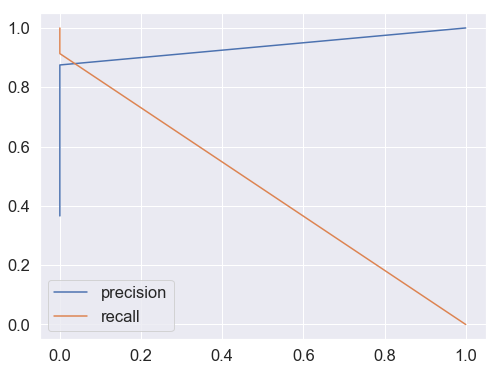

In [87]:
precision, recall, thresholds = precision_recall_curve(y_test_n, y_test_predict)
thresholds = [0] + thresholds.tolist()
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.legend()

Отрисовка AUC

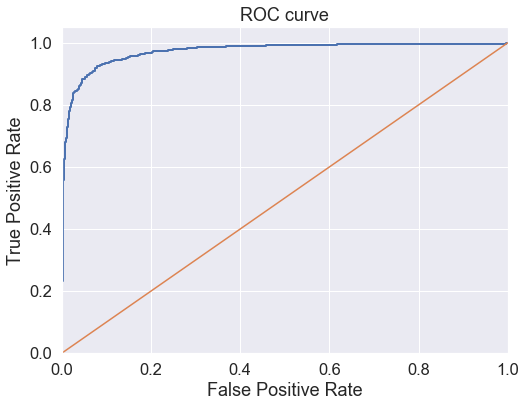

In [88]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test_n, clf_lr.predict_proba(X_test_n)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [189]:
n_dtree = 0.829
list_scores = [knn_n, n_svc, n_dtree, n_rf, sc_gbc, sc_xgb, sc_st_clf, clf_lr_m]

list_classifiers = ['KNN', 'SVC', 'DTREE','RF', 'GBC', 'XGB', 'EXTR', 'STACK', 'LR']


In [190]:
score_subm_knn   = 0.73
score_subm_svc   = 0.83
score_subm_dtree = 0.37
score_subm_rf    = 0.37
score_subm_gbc  = 0.37
score_subm_xgb   = 0.37
score_subm_stack = 0.37
score_subm_lr = 0.92

In [191]:
subm_scores = [score_subm_knn, score_subm_svc, score_subm_dtree, score_subm_rf, 
               score_subm_gbc, score_subm_xgb, score_subm_stack, score_subm_lr]

In [205]:
# в моем юпитере график не отрисовывается, при этом ошибок не возникает
trace1 = go.Scatter(x = list_classifiers, y = list_scores,
                   name="Validation", text = list_classifiers)
trace2 = go.Scatter(x = list_classifiers, y = subm_scores,
                   name="Submission", text = list_classifiers)

data = [trace1, trace2]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)